### Calculo de las curvas de veloc circular

Guardo los archivos: (solo el 1% de las particulas)
- '../_data/velocity/sh*_Vtot.dat'
- '../_data/velocity/sh*_Vstr.dat'
- '../_data/velocity/sh*_Vgas.dat'
- '../_data/velocity/sh*_Vdrk.dat'

Grafico las curvas de veloc circular

In [1]:
import numpy as np
subh = np.loadtxt('../_data/subhalos.dat')

halo_mask, = np.where((subh[:,15]==0) & (subh[:,16]==0))

subh_name = subh[:,0][halo_mask]
subh_ind  = np.int_(subh_name)
# nsubh = len(subh_name)

print(subh_ind)

[ 0  1  3  4  5  6  7  9 20 21 22 27 28 31 33 35 36 37 38 39 41 42 45 46
 49 50 51 53 54 64 65 66 69 73 74 79 84 85 87 88 90 91 92 95 96]


subhalo 000


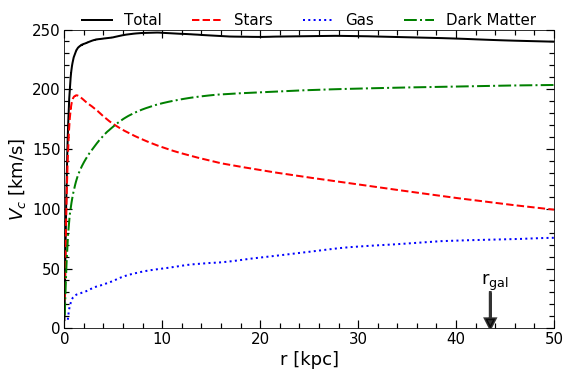

subhalo 001


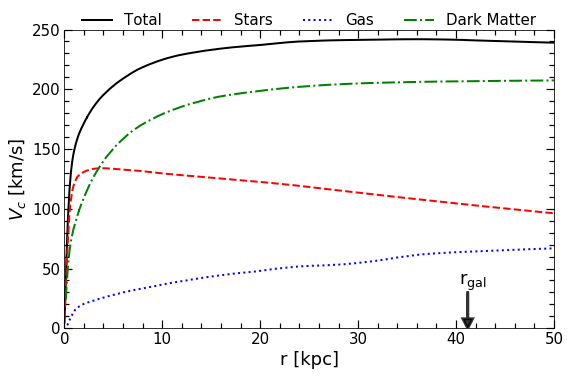

subhalo 003


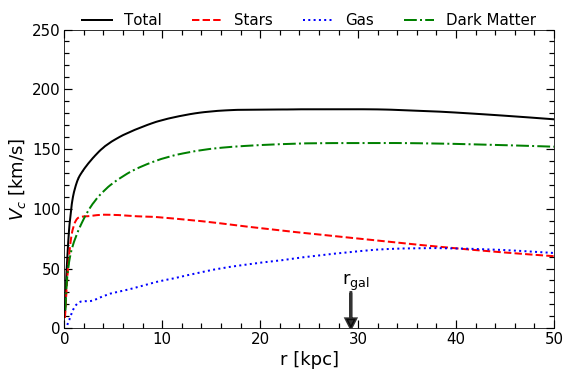

subhalo 004


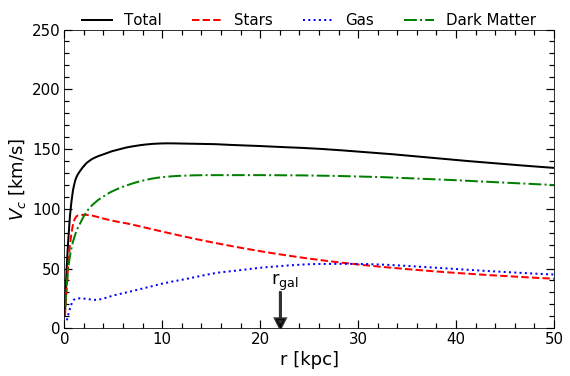

subhalo 005


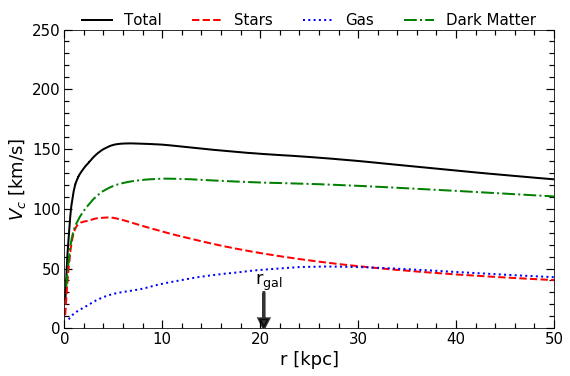

subhalo 006


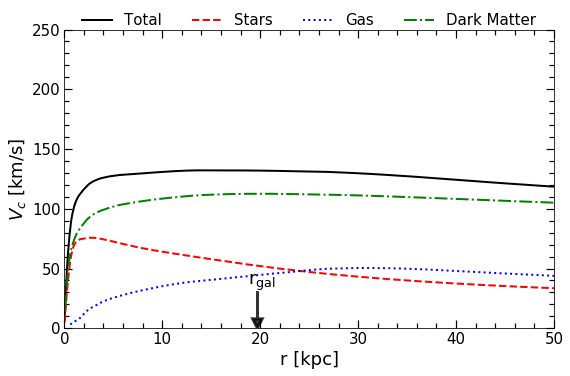

subhalo 007


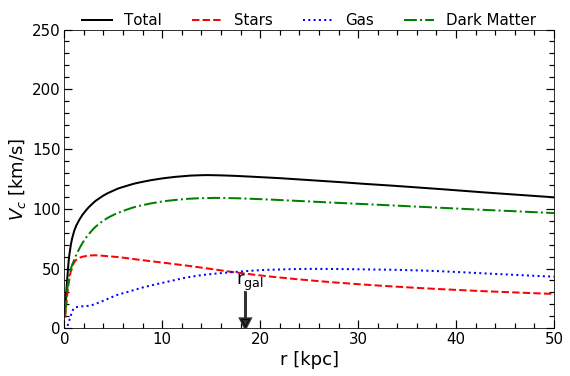

subhalo 009


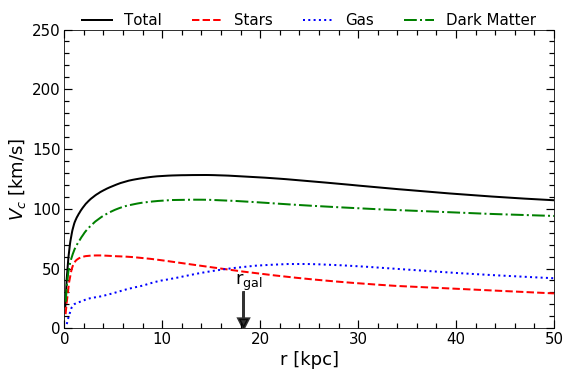

In [3]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import gc
import time_conversion as time
import random

G = 4.299e-6

path = '/z/omarioni/gradients/_simulations/snap_127/'

for j in subh_ind[:8]:

    print('subhalo', str('%03d'%j))
    
    snap = h5py.File(path + 'subhalo_'+str('%03d'%j)+'.h5py', 'r')

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    R200 = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    sft  = snap['/Str/FormationTime'][()]

    pgas = snap['/Gas/Coordinates'][()]
    mgas = snap['/Gas/Masses'][()]

    pdrk = snap['/Drk/Coordinates'][()]
    mdrk = snap['/Drk/Masses'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = pgas[:,0]*aexp/h
    ygas = pgas[:,1]*aexp/h
    zgas = pgas[:,2]*aexp/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = pdrk[:,0]*aexp/h
    ydrk = pdrk[:,1]*aexp/h
    zdrk = pdrk[:,2]*aexp/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h
    mgas = mgas*1e10/h
    mdrk = mdrk*1e10/h
    
    rgal = 0.15*R200
#     print(rgal)

    limit_str   = np.where(rstr<R200)
    rstr_sort   = np.sort(rstr[limit_str])
    rstr_indice = np.argsort(rstr[limit_str])

    limit_gas   = np.where(rgas<R200)
    rgas_sort   = np.sort(rgas[limit_gas])
    rgas_indice = np.argsort(rgas[limit_gas])

    limit_drk   = np.where(rdrk<R200)
    rdrk_sort   = np.sort(rdrk[limit_drk])
    rdrk_indice = np.argsort(rdrk[limit_drk])
    

    Mc_str = np.cumsum((mstr[limit_str])[rstr_indice])

    Mc_gas = np.cumsum((mgas[limit_gas])[rgas_indice])

    Mc_drk = np.cumsum((mdrk[limit_drk])[rdrk_indice])

#--------------------------------------------------------------       
    rtot = np.concatenate([rstr, rgas, rdrk])
    mtot = np.concatenate([mstr, mgas, mdrk])

    limit_tot   = np.where(rtot<R200)
    rtot_sort   = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])

    #print 'Mvir=', Mc_tot[-1], 'r50=', r50[-1]
#--------------------------------------------------------------

    Vtot = np.sqrt((G*Mc_tot)/rtot_sort)
    Vstr = np.sqrt((G*Mc_str)/rstr_sort)
    Vgas = np.sqrt((G*Mc_gas)/rgas_sort)
    Vdrk = np.sqrt((G*Mc_drk)/rdrk_sort)
    
    atot = np.sort(random.choices(np.arange(len(rtot_sort)),k=np.int(len(rtot_sort)*0.01))) 
    adrk = np.sort(random.choices(np.arange(len(rdrk_sort)),k=np.int(len(rdrk_sort)*0.01)))
    astr = np.sort(random.choices(np.arange(len(rstr_sort)),k=np.int(len(rstr_sort)*0.01)))
    agas = np.sort(random.choices(np.arange(len(rgas_sort)),k=np.int(len(rgas_sort)*0.01)))
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))# sharey=True, sharex=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
    fig.subplots_adjust(bottom=0.1, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)

    ax.plot(rtot_sort[atot], Vtot[atot], '-',  lw=2, color='k', label= 'Total')
    ax.plot(rstr_sort[astr], Vstr[astr], '--', lw=2, color='r', label='Stars')
    ax.plot(rgas_sort[agas], Vgas[agas], ':',  lw=2, color='b', label='Gas')
    ax.plot(rdrk_sort[adrk], Vdrk[adrk], '-.', lw=2, color='g', label='Dark Matter')
    ax.arrow(x=rgal,y=30,dx=0,dy=-30,color='k', lw=2.8, alpha=0.8,
             head_length=8,head_width=1,length_includes_head=True)
    ax.text(rgal+0.5, 30,  '$\mathrm{r_{gal}}$',  fontsize=18, color='black',
            ha='center', va='bottom')
    
    ax.set_ylim(0,250)
    ax.set_xlim(0,50)
    ax.set_ylabel(r'$V_{c}$ [km/s]', fontsize=18)
    ax.set_xlabel('r [kpc]', fontsize=18)
    # ax[0,0].set_xticks([0,5,10,15,20,25,30])
    # ax[0,0].set_yticks([50,100,150,200])
    # ax.set_xticklabels([])
    ax.minorticks_on()
    ax.tick_params( labelsize=15)
    ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
    ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
    ax.legend(fontsize=15,loc='upper center', bbox_to_anchor=(0.5, 1.1),
                 ncol=4,frameon=False)

    plt.show()
    
    fig.savefig('../_imagenes/velocities/Vcirc_sh_'+str('%03d'%j)+'.png', 
                dpi = 100, xxbox_inches='tight')

    gc.collect()
#----------------------------------------------------------------------------------
    data_tot = np.zeros([np.size(rtot_sort[atot]),3])
    data_tot[:,0]= rtot_sort[atot]
    data_tot[:,1]= Vtot[atot]
    data_tot[:,2]= Mc_tot[atot]

    data_str = np.zeros([np.size(rstr_sort[astr]),3])
    data_str[:,0]= rstr_sort[astr]
    data_str[:,1]= Vstr[astr]
    data_str[:,2]= Mc_str[astr]

    data_gas = np.zeros([np.size(rgas_sort[agas]),3])
    data_gas[:,0]= rgas_sort[agas]
    data_gas[:,1]= Vgas[agas]
    data_gas[:,2]= Mc_gas[agas]

    data_drk = np.zeros([np.size(rdrk_sort[adrk]),3])
    data_drk[:,0]= rdrk_sort[adrk]
    data_drk[:,1]= Vdrk[adrk]
    data_drk[:,2]= Mc_drk[adrk]

    np.savetxt('../_data/velocity/sh_'+str('%03d'%j)+'_Vtot.dat', data_tot)
    np.savetxt('../_data/velocity/sh_'+str('%03d'%j)+'_Vstr.dat', data_str)
    np.savetxt('../_data/velocity/sh_'+str('%03d'%j)+'_Vgas.dat', data_gas)
    np.savetxt('../_data/velocity/sh_'+str('%03d'%j)+'_Vdrk.dat', data_drk)

### Graficamos con los datos guardados

In [7]:
%time
import gc
import numpy as np

SubH_000  = np.loadtxt('../_data/velocity/sh_000_Vtot.dat')
rtot_subh000 = SubH_000[:,0]
Vtot_subh000 = SubH_000[:,1]
Mtot_subh000 = SubH_000[:,2]

SubH_000  = np.loadtxt('../_data/velocity/sh_000_Vstr.dat')
rstr_subh000 = SubH_000[:,0]
Vstr_subh000 = SubH_000[:,1]
Mstr_subh000 = SubH_000[:,2]

SubH_000  = np.loadtxt('../_data/velocity/sh_000_Vgas.dat')
rgas_subh000 = SubH_000[:,0]
Vgas_subh000 = SubH_000[:,1]
Mgas_subh000 = SubH_000[:,2]

SubH_000  = np.loadtxt('../_data/velocity/sh_000_Vdrk.dat')
rdrk_subh000 = SubH_000[:,0]
Vdrk_subh000 = SubH_000[:,1]
Mdrk_subh000 = SubH_000[:,2]

gc.collect()

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 17.6 µs


0

In [8]:
len(rstr_subh000)

57181

/z/omarioni/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


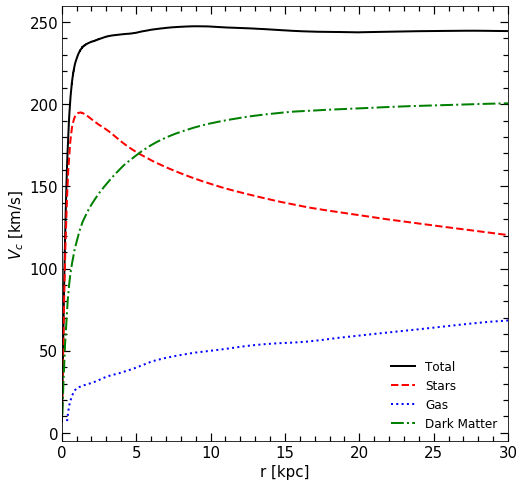

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))# sharey=True, sharex=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
# fig.subplots_adjust(bottom=0.06, left =0.12, right = 0.97, top = 0.97, wspace=0., hspace= 0)

ax.plot(rtot_subh000, Vtot_subh000, '-',  lw=2, color='k', label= 'Total')
ax.plot(rstr_subh000, Vstr_subh000, '--', lw=2, color='r', label='Stars')
ax.plot(rgas_subh000, Vgas_subh000, ':',  lw=2, color='b', label='Gas')
ax.plot(rdrk_subh000, Vdrk_subh000, '-.', lw=2, color='g', label='Dark Matter')
# ax[0,0].set_ylim(0,15)
ax.set_xlim(0,30)
ax.set_ylabel(r'$V_{c}$ [km/s]', fontsize=15)
ax.set_xlabel('r [kpc]', fontsize=15)
# ax[0,0].set_xticks([0,5,10,15,20,25,30])
# ax[0,0].set_yticks([50,100,150,200])
# ax.set_xticklabels([])
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
ax.legend(frameon=False ,fontsize=12)

plt.show()
